##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now, what would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# audio_dir = '/content/drive/MyDrive/Songs/'
audio_dir = '/content/drive/MyDrive/Diplomado/Audio Style Transfer/Bohemian to Huapango'

os.chdir(audio_dir)

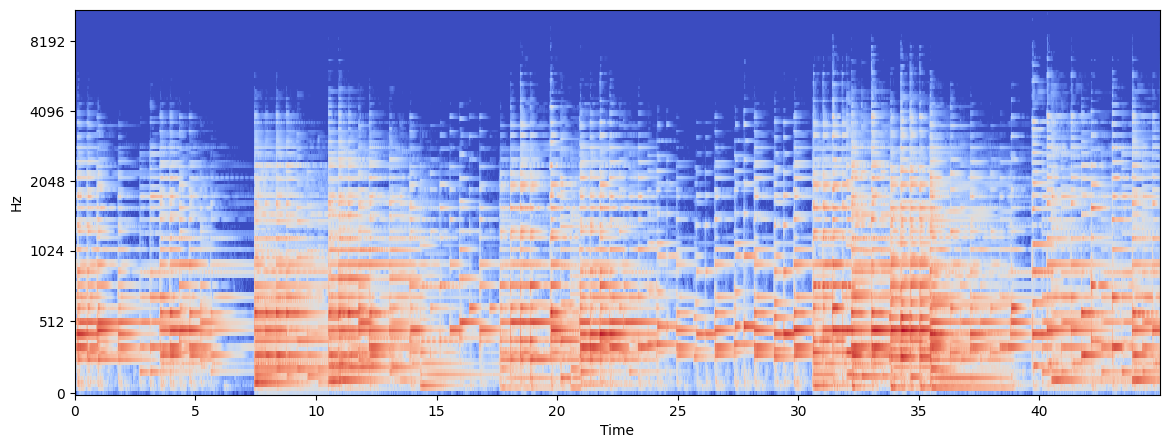

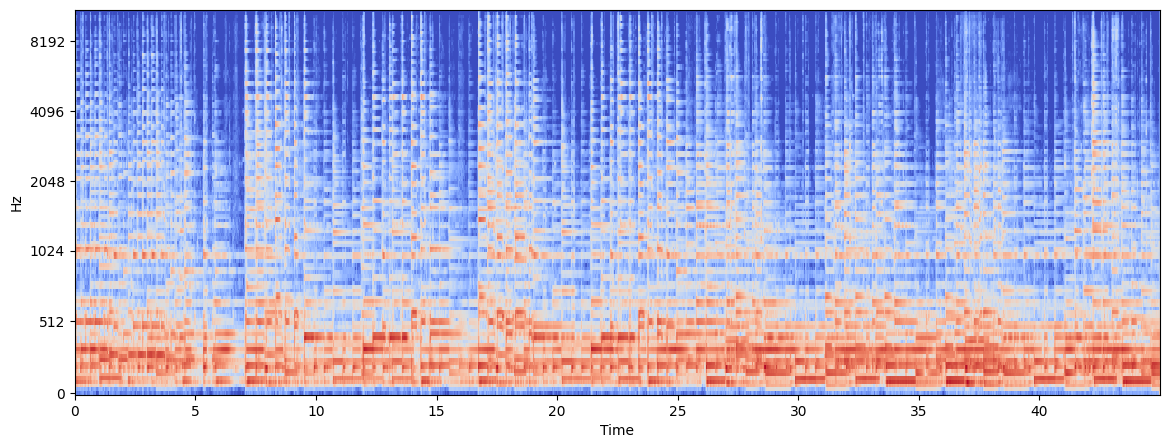

In [ ]:
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


def load_audio_to_mel(path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    y, sr = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y,  # <- this is the fix
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db, sr

# Load both files
mel_content, sr = load_audio_to_mel('short_bohemian.wav')
mel_style, _ = load_audio_to_mel('short_la_bruja.wav')

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_content, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
# plt.colorbar(format='%+2.0f dB')


plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_style, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
# plt.colorbar(format='%+2.0f dB')


# Normalize for neural net input
def to_tensor(mel):
    mel = (mel - mel.mean()) / mel.std()
    mel_tensor = torch.tensor(mel).unsqueeze(0).unsqueeze(0).float()  # shape: [1, 1, H, W]
    mel_tensor = mel_tensor.repeat(1, 3, 1, 1)  # now [1, 3, H, W]

    mel_np = mel_tensor.squeeze(0).permute(1, 2, 0).numpy()  # [H, W, C] permutting
    mel_np = np.expand_dims(mel_np, 0)  # [1, H, W, C]

    mel_np = tf.convert_to_tensor(mel_np, dtype=tf.float32) #getting a tensor

    return mel_np

content_tensor = to_tensor(mel_content)
style_tensor = to_tensor(mel_style)

In [ ]:
content_tensor.shape, style_tensor.shape

(TensorShape([1, 128, 862, 3]), TensorShape([1, 128, 862, 3]))

In [ ]:
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def tensor_to_audio(tensor):
  result = tensor.detach().squeeze().cpu().numpy()
  result = result * mel_content.std() + mel_content.mean()

  # Convert from Mel back to audio
  mel = librosa.db_to_power(result)
  stft = librosa.feature.inverse.mel_to_stft(mel, sr=sr, n_fft=2048)
  audio = librosa.griffinlim(stft, hop_length=512)
  audio_0 = audio[0]

  return audio_0

Download images and choose a style image and a content image:

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = tf.keras.utils.get_file('caravaggio.jpg','https://upload.wikimedia.org/wikipedia/commons/d/d7/Michelangelo_Caravaggio_061.jpg')

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image.shape, style_image.shape

(TensorShape([1, 422, 512, 3]), TensorShape([1, 512, 393, 3]))

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

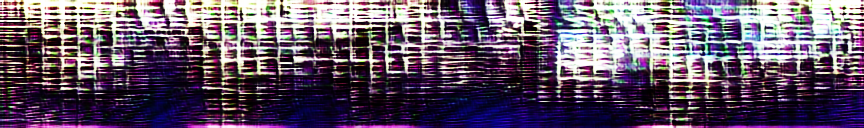

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_tensor), tf.constant(style_tensor))
# content_tensor.shape, style_tensor.shape
tensor_to_image(stylized_image[0])

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_tensor

<tf.Tensor: shape=(1, 128, 862, 3), dtype=float32, numpy=
array([[[[ 0.84774077,  0.84774077,  0.84774077],
         [ 0.49995404,  0.49995404,  0.49995404],
         [-1.2305807 , -1.2305807 , -1.2305807 ],
         ...,
         [-1.0037116 , -1.0037116 , -1.0037116 ],
         [ 0.24113655,  0.24113655,  0.24113655],
         [ 0.86057997,  0.86057997,  0.86057997]],

        [[ 0.83712643,  0.83712643,  0.83712643],
         [ 0.50038034,  0.50038034,  0.50038034],
         [-0.5880556 , -0.5880556 , -0.5880556 ],
         ...,
         [-0.5778886 , -0.5778886 , -0.5778886 ],
         [ 0.30345437,  0.30345437,  0.30345437],
         [ 0.92119646,  0.92119646,  0.92119646]],

        [[ 0.75715894,  0.75715894,  0.75715894],
         [ 0.71499866,  0.71499866,  0.71499866],
         [ 0.6492057 ,  0.6492057 ,  0.6492057 ],
         ...,
         [ 1.200086  ,  1.200086  ,  1.200086  ],
         [ 0.9261176 ,  0.9261176 ,  0.9261176 ],
         [ 1.0349013 ,  1.0349013 ,  1.0349013

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_tensor*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 128, 862, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 128, 862, 64)
  min:  0.0
  max:  2165.0042
  mean:  98.165794

block2_conv1
  shape:  (1, 64, 431, 128)
  min:  0.0
  max:  16242.737
  mean:  625.3488

block3_conv1
  shape:  (1, 32, 215, 256)
  min:  0.0
  max:  20830.477
  mean:  572.35583

block4_conv1
  shape:  (1, 16, 107, 512)
  min:  0.0
  max:  58634.844
  mean:  2246.98

block5_conv1
  shape:  (1, 8, 53, 512)
  min:  0.0
  max:  5249.076
  mean:  138.70795



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns
the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_tensor))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 128, 862, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  402453.97
    mean:  7920.5054

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  2885851.8
    mean:  241719.34

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  18784310.0
    mean:  189152.19

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  89501300.0
    mean:  2989363.8

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1883519.4
    mean:  12586.5

Contents:
   block5_conv2
    shape:  (1, 8, 53, 512)
    min:  0.0
    max:  1767.8069
    mean:  39.622246


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [ ]:
style_targets = extractor(style_tensor)['style']
content_targets = extractor(content_tensor)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_tensor)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e8
content_weight=1

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

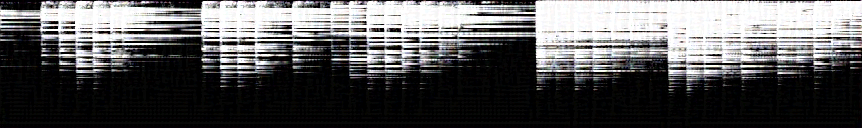

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
image.shape

TensorShape([1, 128, 862, 3])

In [ ]:
import soundfile as sf

def spectrogram_to_waveform(tensor_image, song_name, sr=22050, n_fft=2048, hop_length=512):
    result = tensor_image.numpy()
    result = result[0, :, :, 0]
    result = result * mel_content.std() + mel_content.mean()
    mel = librosa.db_to_power(result)
    stft = librosa.feature.inverse.mel_to_stft(mel, sr=sr, n_fft=2048)
    audio = librosa.griffinlim(stft, hop_length=512)

    sf.write(song_name, audio, sr, format='WAV', subtype='PCM_16')


    return result

In [ ]:
spectrogram_to_waveform(image, "output_test.wav")

array([[-55.86557 , -55.86557 , -55.86557 , ..., -55.86557 , -49.94662 ,
        -40.49774 ],
       [-55.86557 , -55.86557 , -53.449783, ..., -33.867798, -33.867798,
        -33.867798],
       [-52.84896 , -47.02434 , -47.998383, ..., -33.867798, -33.867798,
        -33.867798],
       ...,
       [-55.029175, -55.86557 , -55.19266 , ..., -55.507694, -55.86557 ,
        -55.045345],
       [-55.86557 , -55.86557 , -55.86557 , ..., -55.86557 , -55.86557 ,
        -55.082424],
       [-55.033573, -55.86557 , -55.001026, ..., -55.035072, -55.053474,
        -54.99381 ]], dtype=float32)

In [ ]:
from IPython.display import Audio, display

display(Audio("output_test.wav"))

Since it's working, perform a longer optimization:

In [ ]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 5

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  # display.clear_output(wait=True)
  # display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  spectrogram_to_waveform(image, f"output_test_{step}.wav")
  display(Audio(f"output_test_{step}.wav"))

end = time.time()
print("Total time: {:.1f}".format(end-start))

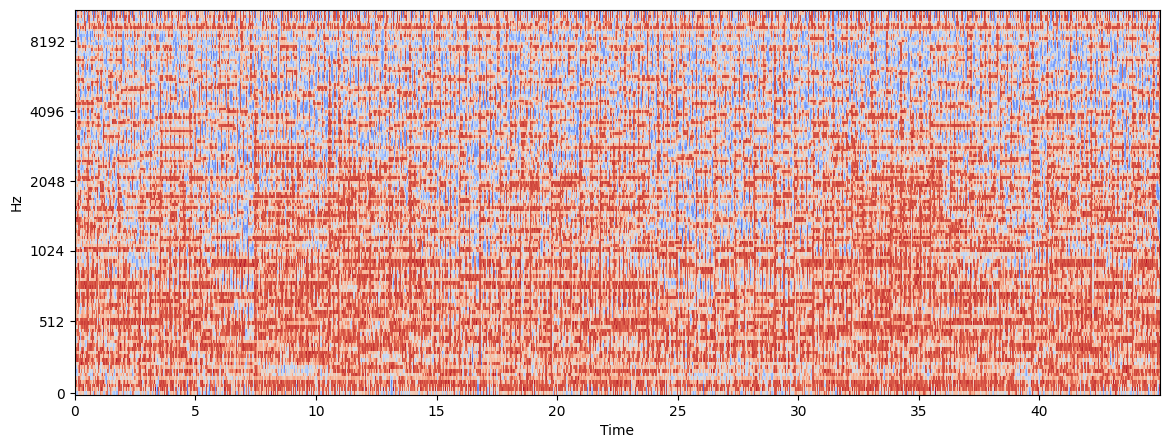

In [ ]:
mel_generated, sr = load_audio_to_mel('output_test_100.wav')

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_generated, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
